# Case Study - Crime Prediction with Logistic Regression
In this case study, we use the Boston Housing dataset to predict if a neighborhood as a crime rate above or below the median crime rate. We will use Logistic Regression for this binary classification problem.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, precision_recall_curve, classification_report
from sklearn import preprocessing
from sklearn import datasets
from IPython.display import display, HTML

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Boston Housing Dataset

This dataset contains information collected by the U.S Census Service concerning housing in the area of Boston Mass. It has been used extensively throughout the literature to benchmark algorithms

### Variables
There are 13 attributes in each case of the dataset. They are:
- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per \$10,000
- PTRATIO - pupil-teacher ratio by town
- B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT - % lower status of the population

### Load data into DataFrame

In [4]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"
boston = pd.read_csv(data_url, sep="\s+", header=None)
columns=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
boston.columns= columns

### Check for missing values, outliers and some basic statistics
It is always a good to do some basic check before starting data analysis. We can check for
- Missing Values
- Outliers
- Some basic descriptive statistics

In [5]:
# Check for missing values
boston.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [6]:
# Descriptive summary

boston.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [7]:
boston.shape

(506, 14)

### Detecting Outliers
**Wikipedia definition**

In statistics, an outlier is a data point that differs significantly from other observations.[1][2] An outlier may be due to variability in the measurement or it may indicate experimental error; the latter are sometimes excluded from the data set.[3] An outlier can cause serious problems in statistical analyses.

#### Visualizing Outliers
A **box-plot** is a useful tool for describing the distribution of data as well as outliers in the data.

**Wikipedia Definition**

In descriptive statistics, a box plot is a method for graphically depicting groups of numerical data through their quartiles. Box plots may also have lines extending vertically from the boxes (whiskers) indicating variability outside the upper and lower quartiles, hence the terms box-and-whisker plot and box-and-whisker diagram. Outliers may be plotted as individual points.


In [8]:
from IPython.display import Image
#Image(filename='image.png')

<Axes: xlabel='DIS'>

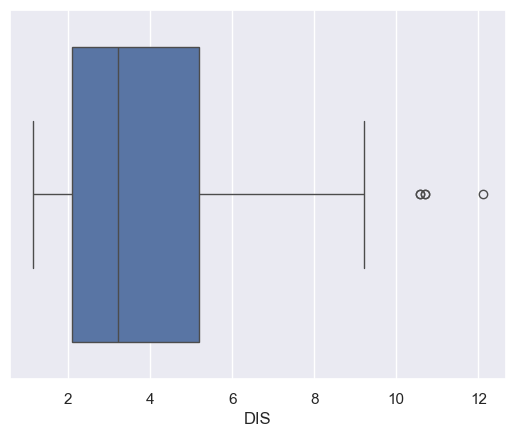

In [9]:
sns.boxplot(x=boston['DIS'])

#### Inter-Quartile Range
**Wikipedia Definition**
The interquartile range (IQR), also called the midspread or middle 50%, or technically H-spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1.

In [10]:
Q1 = boston.quantile(0.25)
Q3 = boston.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

CRIM         3.595038
ZN          12.500000
INDUS       12.910000
CHAS         0.000000
NOX          0.175000
RM           0.738000
AGE         49.050000
DIS          3.088250
RAD         20.000000
TAX        387.000000
PTRATIO      2.800000
B           20.847500
LSTAT       10.005000
MEDV         7.975000
dtype: float64


### Create Target Variable
We need to create our target variable/label. In our case, the outcome we are interested in predicting is whether crime in a neighborhood is above or below the median crime rate in Boston.

In [11]:
target = (boston['CRIM'] > boston['CRIM'].median()).astype(np.float64).rename('target')
boston_df = pd.concat([boston, target], axis=1).drop('CRIM', axis=1)

# distribution of target in the dataset
target.value_counts()

target
0.0    253
1.0    253
Name: count, dtype: int64

## Exploratory Data Analysis (EDA)
Exploratory data analysis (EDA) is an approach to analyzing data sets to summarize their main characteristics, often with visual methods. A statistical model can be used or not, but primarily EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing task.

### Pairwise Relationships
We can see how features interact with each by plotting their pairwise relationships

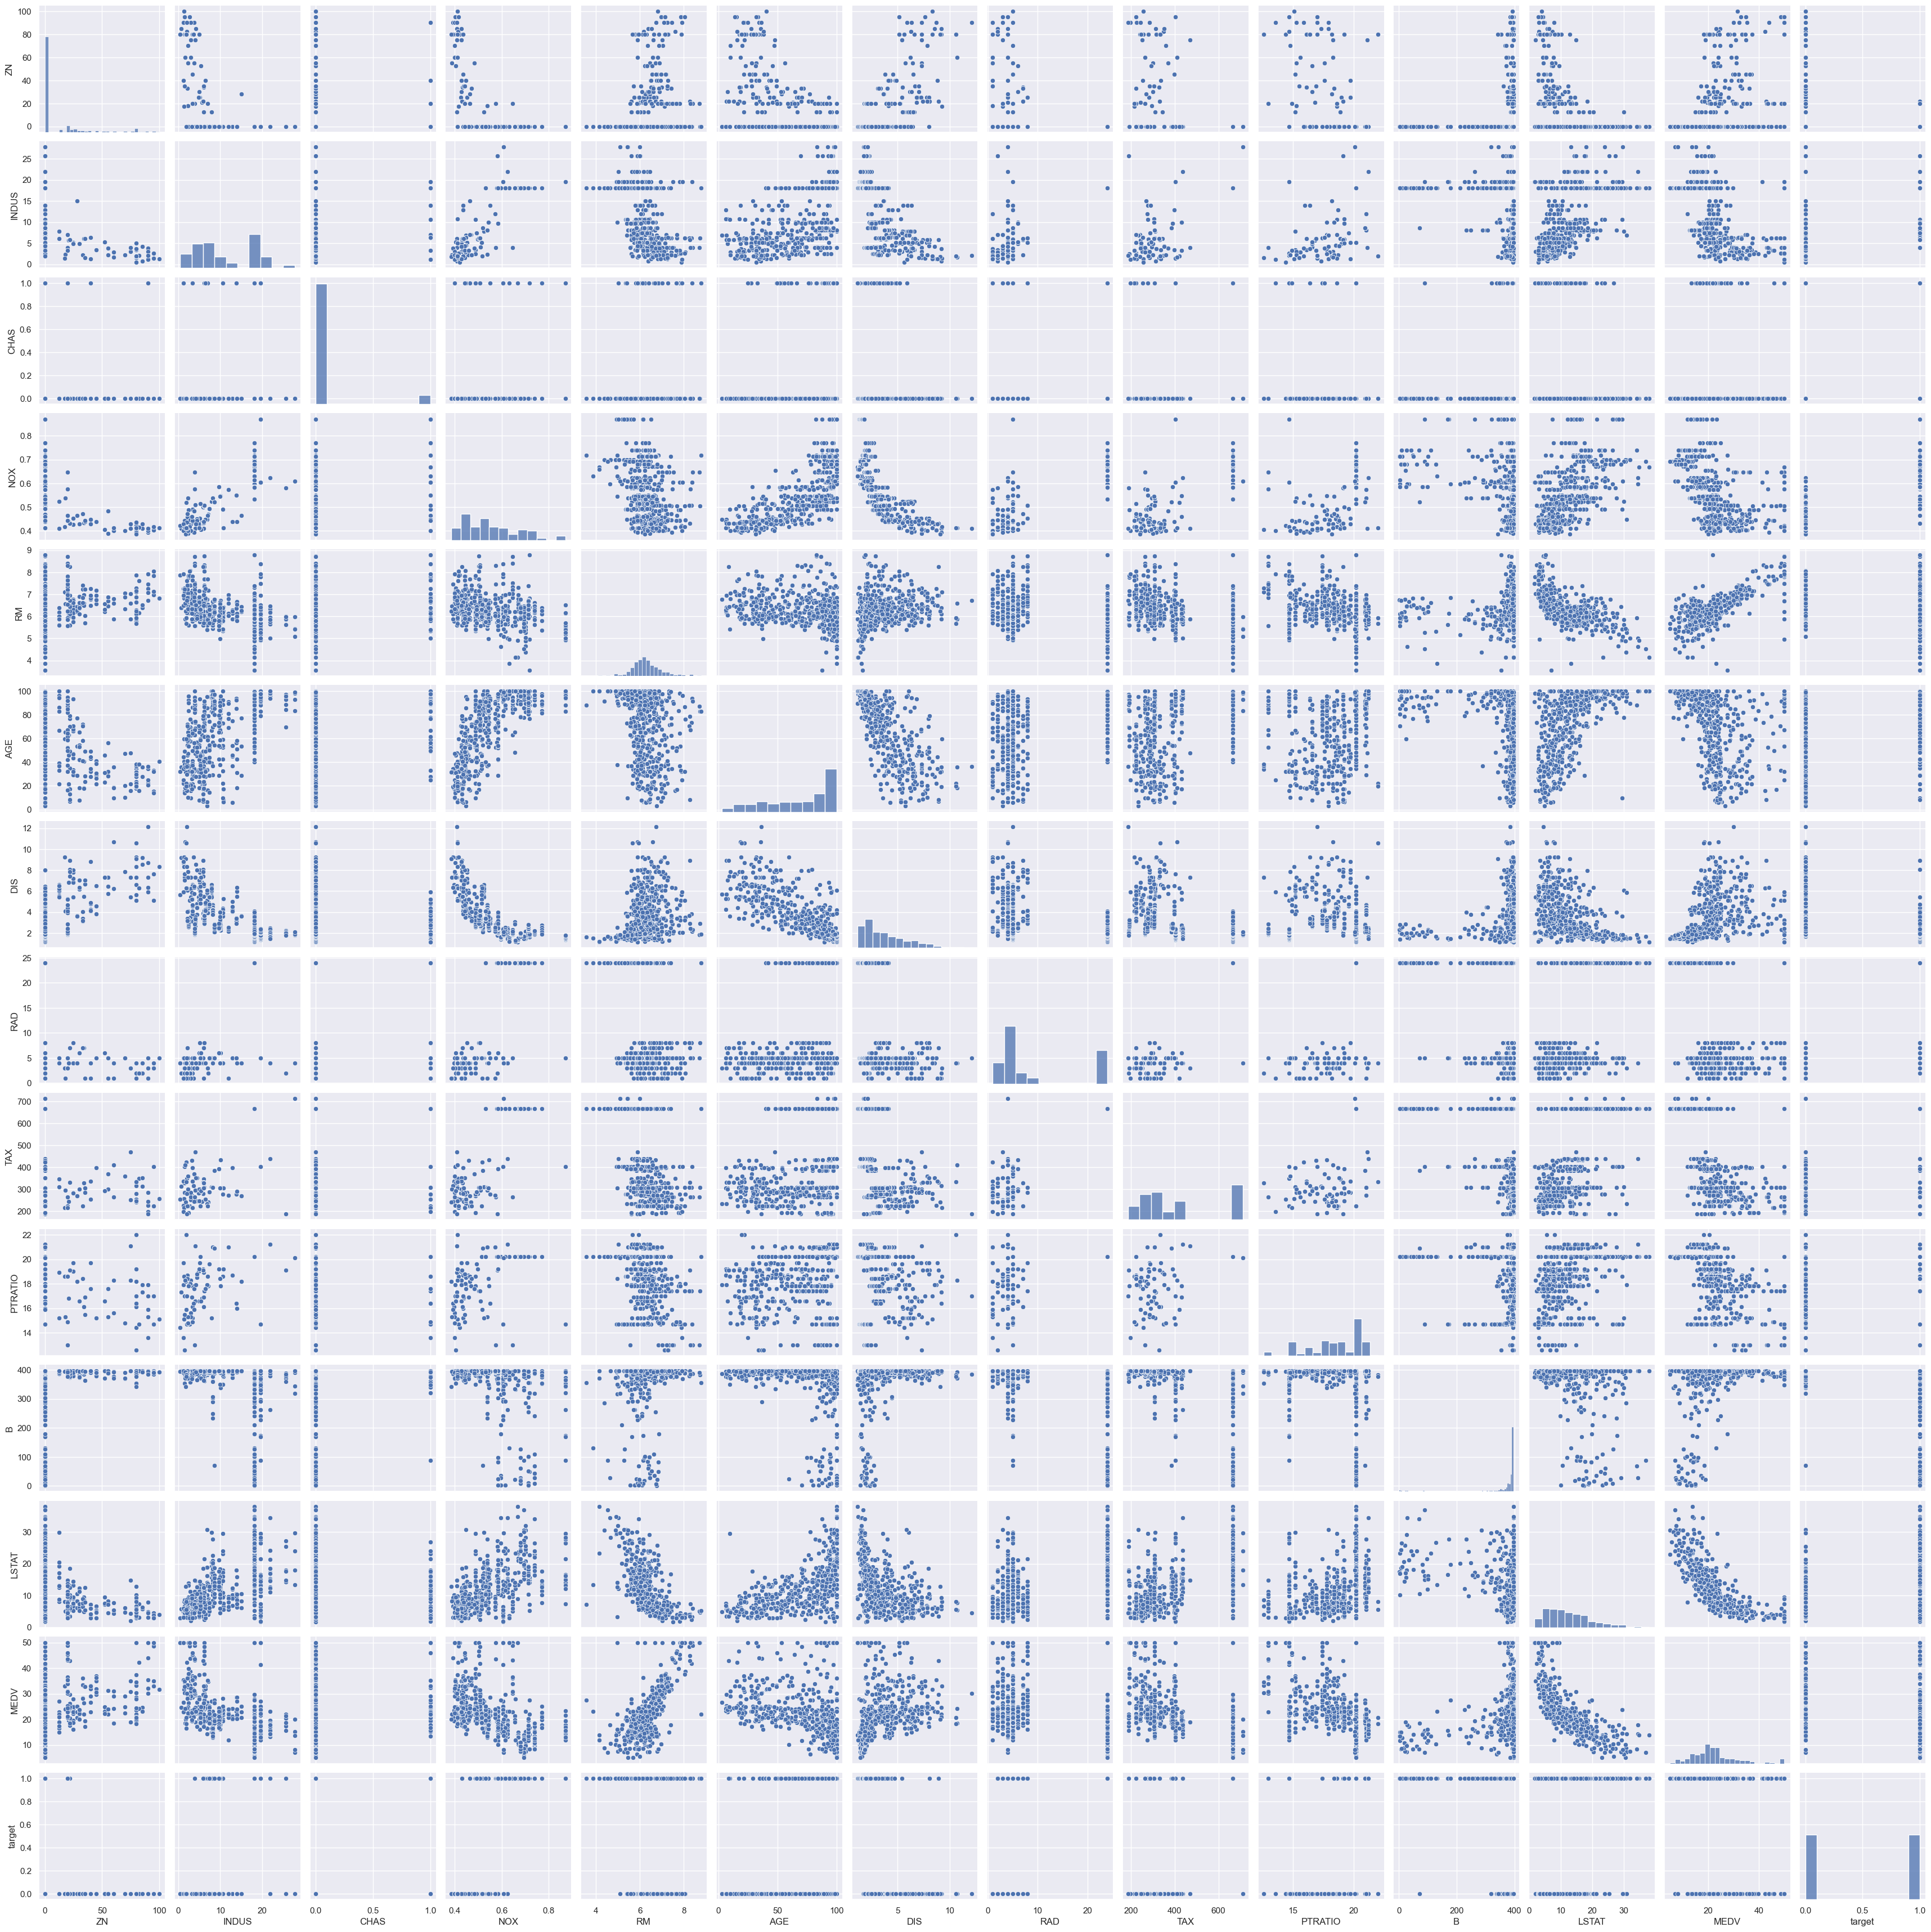

In [12]:
sns.pairplot(boston_df)
plt.show()

### Correlation heatmap
Correlations between variables can be summarized using a correlation heatmap 

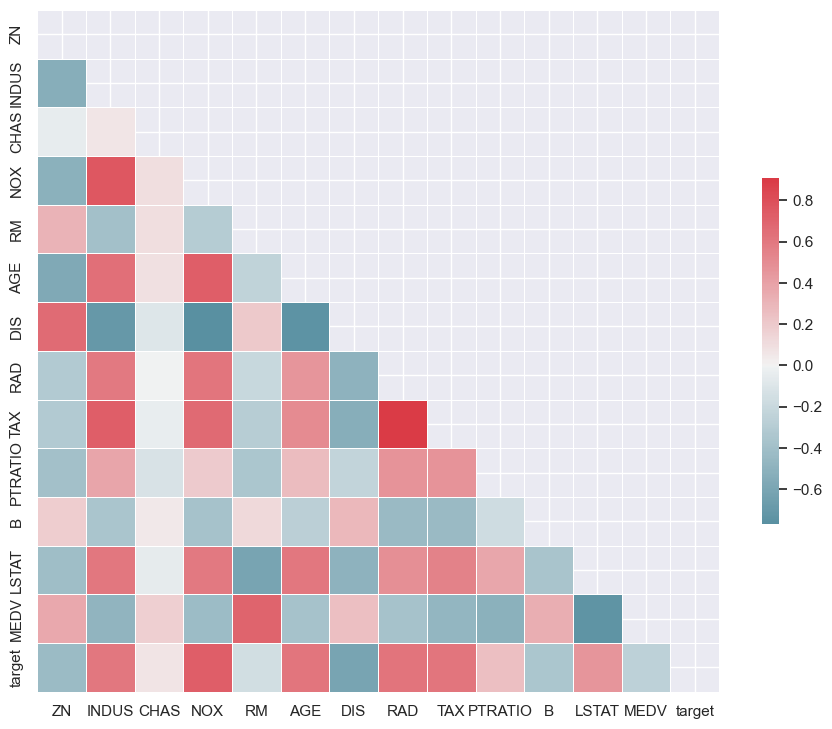

In [ ]:
# Compute the correlation matrix
corr = boston_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### Which features are useful in distinguishing the two classes?
Another way to see how each feature affects the classes and if they have distinguishing capability is to plot a box plot of each feature within each class.

We see that INDUS, NOX and AGE are useful features which can help in distinguishing the two classes.

In [1]:
for c in boston_df.columns.drop(['target']):
    sns.boxplot(x=boston_df['target'], y=boston_df[c])
    plt.show()

NameError: name 'boston_df' is not defined

## Machine Learning

We can now move to fitting a machine learning model. The first step is to divide the data into train and test sets. We typically also create a validation set for hyperparameter optimization. Creating a validation set and optimizing parameters of the Logistic Regression to improve performance is left as an exercise.

In [ ]:
# create train-test splits
# Note that this is a balanced binary classification problem so stratification is not really needed

from sklearn.model_selection import train_test_split
X = boston_df.iloc[:,:-1]
y = boston_df.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=0)
print('Train data size: {}'.format(X_train.shape))
print('Test data size: {}'.format(X_test.shape))

Train data size: (354, 13)
Test data size: (152, 13)


In [ ]:
# Logistic Regression
logit       = LogisticRegression()
model_logit = logit.fit(X_train, y_train)

In [ ]:
# predictions
y_pred = model_logit.predict(X_test)

## Performance Evaluation
Appropriate performance evaluation is an important step in machine learning. We must define metrics that make sense for the problem and are closely tied to the business value we hope to create from the model

Confusion matrix is a good tool to see how good our classification model is.

In [ ]:
confusion_mtx = confusion_matrix(y_test, y_pred)

confusion_mtx

array([[67, 11],
       [13, 61]], dtype=int64)

In [ ]:
# Calculating accuracy, precision and recall

print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {}'.format(precision_score(y_test, y_pred)))
print('Recall: {}'.format(recall_score(y_test, y_pred)))

Accuracy: 0.8421052631578947
Precision: 0.8472222222222222
Recall: 0.8243243243243243


### Classification Report
Classification Report summarizes the above metrics by building a text report

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.86      0.85        78
         1.0       0.85      0.82      0.84        74

    accuracy                           0.84       152
   macro avg       0.84      0.84      0.84       152
weighted avg       0.84      0.84      0.84       152



### Precision-Recall curve

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

In [ ]:
y_score = model_logit.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_score[:,1])

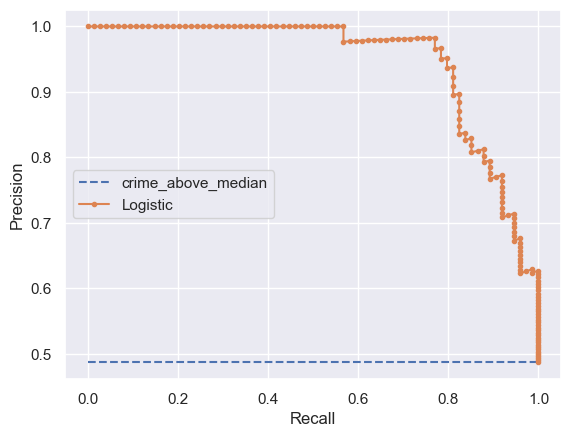

In [ ]:
crime_above_median = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [crime_above_median, crime_above_median], linestyle='--', label='crime_above_median')
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()